# Symmetric Monoidal Categories


This vignette supports section 4.4.3 of Seven Sketches in Compositionality, which introduces the definition of symmetric monoidal categories (SMCs). SMCs are a core concept in applied category theory and are a workhorse of Catlab's utility in computing applications. We will discuss the definition as a GAT, see examples of working with formulas, and conversions to wiring diagrams (sometimes called string diagrams). SMCs are useful for modeling mathematical structures like programs or processes where the objects represent data or things and the morphisms represent processes that happen to those things.

In [1]:
using GATlab, Catlab.Theories
using Catlab.CategoricalAlgebra
using Catlab.WiringDiagrams
using Catlab.Programs
using Catlab.Graphics
using Catlab.Graphics: Graphviz

draw(d::WiringDiagram) = to_graphviz(d,
  orientation=LeftToRight,
  labels=true, label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(
    :fontname => "Courier",
  ),
  edge_attrs=Graphviz.Attributes(
    :fontname => "Courier",
  )
)

draw (generic function with 1 method)

## Definition
Let 𝒞 be a category, then a strict symmetric monoidal structure on 𝒞 has as data:
1. An object I called the monoidal unit
2. A functor ⊗: 𝒞×𝒞 → 𝒞 called the monoidal product.
3. A natural isomorphism σᵃᵇ: A⊗B → B⊗A

It has as axioms:
1. Left identity) I⊗C = C for all objects C in 𝒞
2. Right identity) C⊗I = C for all objects C in 𝒞
3. Associativity) (A⊗B)⊗C = A⊗(B⊗C) for all objects A,B,C in 𝒞
4. Involutivity) σ(σ(A,B)) = id(A⊗B)

In a category, you have a composition operation that captures the sequential kind of composition. For example in Set, you compose two functions f⋅g by first applying f and then applying g. In monoidal categories, you also have the parallel composition ⊗ which you can think of as representing the simultaneous exectution of two processes. We are familiar with the cartesian product in Set which takes two sets and forms the cartesian product. The cartesian product acts on functions in a similar way, f×g is the function that takes a tuple (x:dom(f),y:dom(g)) and applies them *in parallel* and returns (f(x), g(y)):(codom(f)×codom(g)). The axioms of an SMC require that these two operations work together. The Seven Sketches book suppresses an interesting axiom called the *interchange law* for brevity, but it is worth calling some attention to it. In order for the sequential and parallel composition operators to capture our intuition, we need to assert that for any functions with compatible domains we can interchange parallel and sequential operators. Formally, ((f ⊗ g) ⋅ (h ⊗ k) == (f ⋅ h) ⊗ (g ⋅ k) where (A::Ob, B::Ob, C::Ob, X::Ob, Y::Ob, Z::Ob, f::(A → B), h::(B → C), g::(X → Y), k::(Y → Z))). This axiom says that doing f and g in parallel and then h and k in parallel is the same as doing (f then h) and (g then k) in parallel. When using SMCs to model processes, this axiom is critical to making sure that scheduling those processes is coherent.

If the SMC is not strict, then the equations are replaced by natural isomorphisms. The choice of natural isomorphisms then becomes part of the data of the SMC. With MacLane's coherence theorem for SMCs mathematicians can think about strict SMCs and not really worry too much about the natural isomorphisms. As programmers, those chickens come home to roost and implementing an SMC requires making some choices about about how to do that strictification.

The Catlab definitions of SMC are repeated here for convenience. Catlab allows you to implement mathematical definitions in the language of Generalized Algebraic Theories (GATs), which are a good fit for the kind of natural language definitions that mathematicians will write. Because Catlab does relatively little type inference, the GAT version of a definition can be more verbose than you would get in natural language. For example, we have to be careful about spelling out the object for an identity morphism `id(A):A → A`. The notation  `@theory MonoidalCategory{Ob,Hom} <: Category{Ob,Hom}` says that a Monoidal Category is a type of Category with additional components and axioms. Catlab has only rudimentary support for Monoidal Categories that are not Symmetric Monoidal Categories. But we separate out the definitions for completeness.
```julia
@theory MonoidalCategory{Ob,Hom} <: Category{Ob,Hom} begin
  otimes(A::Ob, B::Ob)::Ob
  otimes(f::(A → B), g::(C → D))::((A ⊗ C) → (B ⊗ D)) ⊣
    (A::Ob, B::Ob, C::Ob, D::Ob)
  @op (⊗) := otimes
  munit()::Ob
  # Monoid axioms.
  #
  # The last two axioms are the naturality equations associated with the left
  # and right unitors, in the strict case where they are identities.
  (A ⊗ B) ⊗ C == A ⊗ (B ⊗ C) ⊣ (A::Ob, B::Ob, C::Ob)
  munit() ⊗ A == A ⊣ (A::Ob)
  A ⊗ munit() == A ⊣ (A::Ob)
  (f ⊗ g) ⊗ h == f ⊗ (g ⊗ h) ⊣ (A::Ob, B::Ob, C::Ob, X::Ob, Y::Ob, Z::Ob,
                                f::(A → X), g::(B → Y), h::(C → Z))
  id(munit()) ⊗ f == f ⊣ (A::Ob, B::Ob, f::(A → B))
  f ⊗ id(munit()) == f ⊣ (A::Ob, B::Ob, f::(A → B))
  # Functorality axioms.
  ((f ⊗ g) ⋅ (h ⊗ k) == (f ⋅ h) ⊗ (g ⋅ k)
    ⊣ (A::Ob, B::Ob, C::Ob, X::Ob, Y::Ob, Z::Ob,
       f::(A → B), h::(B → C), g::(X → Y), k::(Y → Z)))
  id(A ⊗ B) == id(A) ⊗ id(B) ⊣ (A::Ob, B::Ob)
end
```
To the definition of a monoidal category, we need to add the symmetry component. Catlab calls the swap morphism a braid, because that is how you visualize it in wiring diagrams, but we stick with the conventional σ unicode name. The macro `@op` tells Catlab that you want to use a unicode operator as an alias for you term constructor. If you are familiar with type theory, you might be wondering why we write the context after the terms. This is because human brains are pretty good at type inference based on notational convention and we want to mimic the English idiom "f⋅g, where f:A→B and g:B→C are functions".
```julia
@theory SymmetricMonoidalCategory{Ob,Hom} <: MonoidalCategory{Ob,Hom} begin
  braid(A::Ob, B::Ob)::((A ⊗ B) → (B ⊗ A))
  @op (σ) := braid
  # Involutivity axiom.
  σ(A,B) ⋅ σ(B,A) == id(A ⊗ B) ⊣ (A::Ob, B::Ob)
  # Coherence axioms.
  #
  # Note: The last two axioms are deducible from the first two axioms together
  # with the naturality equations for the left/right unitors. We record them for
  # the sake of clarity and uniformity.
  σ(A,B⊗C) == (σ(A,B) ⊗ id(C)) ⋅ (id(B) ⊗ σ(A,C)) ⊣ (A::Ob, B::Ob, C::Ob)
  σ(A⊗B,C) == (id(A) ⊗ σ(B,C)) ⋅ (σ(A,C) ⊗ id(B)) ⊣ (A::Ob, B::Ob, C::Ob)
  σ(A,munit()) == id(A) ⊣ (A::Ob)
  σ(munit(),A) == id(A) ⊣ (A::Ob)
  # Naturality axiom.
  (f ⊗ g) ⋅ σ(B,D) == σ(A,C) ⋅ (g ⊗ f) ⊣ (A::Ob, B::Ob, C::Ob, D::Ob,
                                          f::(A → B), g::(C → D))
end
```

## Presentations
Just like how a preorder can be presented with Hasse Diagram or a free category can be presented by a Graph, SMCs can be presented syntactically or combinatorially. We first start with the syntactic presentation using `@present`.

In [2]:
@present Cooking(FreeSymmetricMonoidalCategory) begin
  (WholeEgg, RawEgg, Shell, Egg, Pan, Cheese, Scramble)::Ob
  crack::Hom(WholeEgg, RawEgg⊗Shell)
  fry::Hom(RawEgg⊗Pan, Egg⊗Pan)
  scramble::Hom(RawEgg⊗Cheese⊗Pan, Scramble⊗Pan)
end
generators(Cooking)

10-element Vector{Any}:
 WholeEgg
 RawEgg
 Shell
 Egg
 Pan
 Cheese
 Scramble
 crack: WholeEgg → RawEgg⊗Shell
 fry: RawEgg⊗Pan → Egg⊗Pan
 scramble: RawEgg⊗Cheese⊗Pan → Scramble⊗Pan

One interpretation of an SMC is that the objects are resources and the Homs are processes the domain of the Hom is the list of resources that you need to perform the process and the codomain is the list of resources that the process produces. You can think of the SMC presentation as a namespace containing all the terms in the SMC.

The objects and morphisms are accessible by name

In [3]:
Cooking[:Egg]
Cooking[:fry]

fry: RawEgg⊗Pan → Egg⊗Pan

Then you can make complex terms using the unicode operators

In [4]:
((Cooking[:crack]⋅σ(Cooking[:RawEgg], Cooking[:Shell])) ⊗id(Cooking[:Pan])) ⋅ (id(Cooking[:Shell])⊗Cooking[:fry])

((crack⋅(RawEggσShell))⊗id{Pan})⋅(id{Shell}⊗fry): WholeEgg⊗Pan → Shell⊗Egg⊗Pan

Notice that Catlab will display the expected domain and codomain.

This is called point-free notation an it is very popular in the functional programming literature where it is used to mean implicit universal quantification over the function arguments. You can think of a morphism like a function that takes an element of each domain object as input and produces an element of each codomain object as output. Not all SMCs have interpretations as functions over sets, but just like groups can be viewed as a generalization of the symmetries of geometric shapes, SMCs can be viewed as a generalization of multivariate functions.

These presentations are very syntactic objects and expose an API for manipulating expressions.

In [5]:
for g in generators(Cooking)
  "$g is a $(gat_typeof(g)) with arguments $(gat_type_args(g))"
end

The `gat_typeof` function computes the algebraic type of a term by analogy to `Base.typeof` which computes the Julia type of a value.

In [6]:
homs = filter(generators(Cooking)) do g
  gat_typeof(g) == :Hom
end

3-element Vector{Any}:
 crack: WholeEgg → RawEgg⊗Shell
 fry: RawEgg⊗Pan → Egg⊗Pan
 scramble: RawEgg⊗Cheese⊗Pan → Scramble⊗Pan

When the term is a Hom, you can get the domain and codomain of the morphism with the `dom` and `codom` functions.

In [7]:
map(homs) do f
  "$f: $(dom(f)) → $(codom(f))"
end

3-element Vector{String}:
 "crack: WholeEgg → otimes(RawEgg,Shell)"
 "fry: otimes(RawEgg,Pan) → otimes(Egg,Pan)"
 "scramble: otimes(RawEgg,Cheese,Pan) → otimes(Scramble,Pan)"

The terms in a `FreeSymmetricMonoidalCategory` are trees that you can navigate with `head` and `args`. The `head` of an expression is the term constructor that created it. For SMCs, this can be `:generator`, `:otimes`, `:compose`, `:id`, or `:braid`. Then `args` will give you the list of arguments to the term constructor. For terms of type Object, this will just be the list of objects that went into constructing the object. For example A⊗B⊗C will have as its head `:otimes` and as the args `[A,B,C]`. Note that the head is a symbol, but the args are objects. For a term of type `Hom`, you have the same structure, but for Homs with the head `:generator`, you get the name of the morphism as a symbol as the first argument.

We can look at the head and args of object expressions.

In [8]:
headargs(x) = (head(x),args(x))
σ(Cooking[:Egg], Cooking[:Pan]) |> headargs

(:braid, Catlab.Theories.FreeSymmetricMonoidalCategory.Ob{:generator}[Egg, Pan])

And, morphsims

In [9]:
headargs(Cooking[:crack]⊗Cooking[:fry])

(:otimes, Catlab.Theories.FreeSymmetricMonoidalCategory.Hom{:generator}[crack, fry])

The base case is generators

In [10]:
headargs(Cooking[:Egg])

(:generator, [:Egg])

And, morphisms

In [11]:
headargs(Cooking[:crack])

(:generator, Any[:crack, WholeEgg, otimes(RawEgg,Shell)])

For a more complete introspection of the expression trees, you can call `dump(ex)` which will print a very verbose representation of the entire expression tree.

In order to compose morphisms sequentially, you have to make sure that the domains match up. In a typical SMC expression this can require padding with the identity morphism and braiding monoidal products into the right order.

In [12]:
compose(Cooking[:crack]⊗id(Cooking[:Pan]),
        (id(Cooking[:RawEgg])⊗ σ(Cooking[:Shell], Cooking[:Pan])),
        (Cooking[:fry]⊗id(Cooking[:Shell])))

(crack⊗id{Pan})⋅(id{RawEgg}⊗(ShellσPan))⋅(fry⊗id{Shell}): WholeEgg⊗Pan → Egg⊗Pan⊗Shell

At some point, prefix notation is more scalable than infix notation, so you might write this as a LISP programmer would.

In [13]:
compose(
  otimes(Cooking[:crack],
         id(Cooking[:Pan])),
  otimes(id(Cooking[:RawEgg]),
         σ(Cooking[:Shell], Cooking[:Pan])),
  otimes(Cooking[:fry],
         id(Cooking[:Shell])))

(crack⊗id{Pan})⋅(id{RawEgg}⊗(ShellσPan))⋅(fry⊗id{Shell}): WholeEgg⊗Pan → Egg⊗Pan⊗Shell

You can view this padding as requiring explicit instructions to do noting with all the objects you aren't using. In this example, we have to tell our chef
1. Crack the egg and do nothing with the pan.
2. Do nothing with the egg and swap the shell with the pan.
3. Fry the egg and do nothing with the shell.
Obviously, this is a very tedious way to write recipes. You need to have some syntactic sugar for all this padding and swapping.

## The Program Macro
The syntactic API above is useful for manipulating terms in an arbitrary GAT and is the formal language of Catlab for representing and manipulating algebraic structures. However, when we want to work with big expressions in an SMC, the tree structure inherent to formulas is too verbose, and we want to move to a port-graph structure called `DirectedWiringDiagrams`. This gives us the benefits of combinatorial data structures like graphs with the right expressional power for representing the morphisms in an SMC.

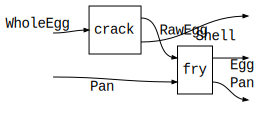

In [14]:
recipe = @program Cooking (e::WholeEgg, p::Pan) begin
  e′, shell = crack(e)
  return shell, fry(e′, p)
end
draw(recipe)

Catlab gives you the tools for drawing wiring diagrams. Visualization of wiring diagrams is the oldest part of Catlab and the original motivation for its development. The `@program` macro allows you to define wiring diagrams using a syntax that feels like Julia code.

The input wires are declared as *arguments* to the program, and the output wires are declared as *returns* from the function. Variables that are not consumed or by another function or returned by the program are automatically dropped.

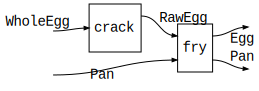

In [15]:
recipe = @program Cooking (e::WholeEgg, p::Pan) begin
  e′, shell = crack(e)
  return fry(e′, p)
end
draw(recipe)

You can copy a value by using it more than once. This is visualized as a wire being split into two wires. Square brackets let you assert equality again. For material goods, you might not want to allow this merging and splitting.

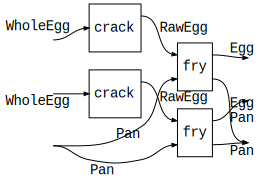

In [16]:
recipe = @program Cooking (e₁::WholeEgg, e₂::WholeEgg, p::Pan) begin
  e, shell = crack(e₁)
  r₁, p₁ = fry(e, p)
  e, shell = crack(e₂)
  r₂, p₂ = fry(e, p)
  return r₁, r₂, [p₁,p₂]
end

draw(recipe)

You can visualize the copy and delete morphisms explicitly with the `add_junctions` function. The dots with one wire input and multiple outputs are copying values and dots with no wires out are deletions (discarding values). Not all instances of a `SymmetricMonoidalCategory` support copy and delete, for example, in manufacturing you can't duplicate a resource, and in chemistry you can't discard species. Catlab would enforce that when you tried to interpret the wiring diagram in a specific SMC.

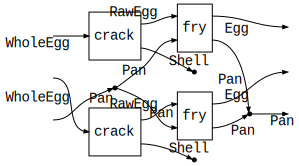

In [17]:
draw(add_junctions(recipe))

For more details about working with wiring diagrams in Catlab, you should look at the vignettes under wiring_diagrams which explain how wiring diagrams interact with SMC expressions and the basics of constructing and manipulation wiring diagrams.